In [784]:
import pandas as pd
import datetime as dt
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Table of Contents

1. [Reviews](#reviews)
 * [Clickstream](#clickstream)
 * [Length](#length)
 * [Conversion](#conversion)
2. [Last Click Analysis](#last)
3. [Last Relevant Click Analysis](#lastrel)
4. [Markov Chain](#markov)
 * [Path Buyers](#buyers)
 * [Path Non-buyers](#nonbuyers)
 * [Path Males](#males)
 * [Path Females](#females)

## Celebrity reviews vs. customer reviews vs. video reviews<a class="anchor" id="reviews"></a>

I decided to do several analysis to identify which review type is more influential and effective:
1. Analyze the whole path of **clickstreams** per user that led to a purchase and out of all the purchases identify if the purchase was made after reading celebrity reviews, customer or video reviews or none. This will help us to identify a channel that led to the highest percentage of purchases. 
2. **Length** of the customer journey per review type: As part of the same analysis compare the length of the clickstream path that ended with a purchase after customer read a review, celebrity recommendation or video review. The shorter the path, the more effective is the review source
3. Compare **conversion rates** for customer, celebrity and video reviews: Out of all customers who read only customer or only celebrity reviews or only watched the video reviews, what percentage bought the product at the end.

Looking at **gender** and **birthdate**, I see that not all user sessions are populated. For example, only 13,380 of the 16,929 total purchases made contain information on gender. I will make use of gender if there are any useful patterns. However, we can see that most purchasers were born in the 1980s-90s, so there is an imbalance there. Furthermore, given that I don't have any other context about product, it is difficult to  identify meaningful age groups. If I had the information about the product the next step would be to also analyse the behavior among reasonably defined age groups. Therefore, I don't analyse date of birth further.

In [1352]:
clickstream_data = pd.read_csv('HW3_data/clickstream-feed-generated.tsv', sep='|', 
                               names = ['clickstream_id','timestamp','IP_address','url','is_purchased','is_page_errored','user_session_id','city','state','country'])

sex_birth_data = pd.read_csv('HW3_data/regusers.tsv', sep='\t', header = 0)
# Merge
clickstream_data = pd.merge(clickstream_data, sex_birth_data, how= 'left', left_on='user_session_id', right_on='SWID')

In [1353]:
# Sort data by IP and timestamp
clickstream_data.sort_values(['IP_address', 'timestamp'], inplace=True)
clickstream_data.reset_index(inplace=True)

In [1354]:
# Add Product Reference Column
clickstream_data['product'] = clickstream_data['url'].apply(lambda x: x[-1] if x[-1] in ('1','2','3','4','5') else "home")

# Convert timestamp to datetime
clickstream_data['timestamp'] = pd.to_datetime(clickstream_data['timestamp'])
clickstream_data['BIRTH_DT'] = pd.to_datetime(clickstream_data['BIRTH_DT'], format = '%d-%b-%y')

# Add column with only the date
clickstream_data["date"] = [d.date() for d in clickstream_data["timestamp"]]

# Add this cumulative count as some IP-time pairs appear multiple times, which messes up the lagged URL function underneath
clickstream_data['IP_click_count'] = clickstream_data.groupby(['IP_address'])['url'].cumcount() # used to be groupby(['IP_address', 'date'])

In [1355]:
# Extract year of birth
clickstream_data['year'] = clickstream_data['BIRTH_DT'].apply(lambda x: x.date().year if ~ pd.isnull(x) else "")

We can see that there are an equal number of purchases made by Males, Females, and about 50% less by Unidentified.

In [1356]:
# Breakdown of purchases by Gender
clickstream_data[(clickstream_data['is_purchased'] == 1) 
                 & ( ~ clickstream_data['GENDER_CD'].isna()) ].groupby('GENDER_CD')[['index']].count()

index
GENDER_CD       
F           5572
M           5330
U           2478

In [1357]:
# Purchases made by people born in different years
clickstream_data[clickstream_data['is_purchased']==1].groupby('year')[['index']].count().sort_values('index', ascending= False).head(10)

index
year         
1989.0    728
1990.0    712
1988.0    711
1986.0    657
1987.0    630
1985.0    607
1991.0    593
1992.0    546
1983.0    542
1984.0    520

In [1358]:
# Remove unneeded columns
clickstream_data.drop(columns = ['SWID', 'BIRTH_DT','year'], inplace = True)

In [1331]:
clickstream_data.head()

index  clickstream_id           timestamp    IP_address  \
0  415401      1331866529 2012-03-15 19:55:29  100.1.113.13   
1  415405      1331866538 2012-03-15 19:55:38  100.1.113.13   
2  415407      1331866539 2012-03-15 19:55:39  100.1.113.13   
3  415416      1331866554 2012-03-15 19:55:54  100.1.113.13   
4  415472      1331866610 2012-03-15 19:56:50  100.1.113.13   

                              url  is_purchased  is_page_errored  \
0  http://www.RL.com/product/4002             0              0.0   
1              http://www.RL.com/             0              0.0   
2  http://www.RL.com/product/4001             0              0.0   
3  http://www.RL.com/product/4003             0              0.0   
4  http://www.RL.com/product/4002             0              0.0   

                        user_session_id        city state country GENDER_CD  \
0  2305C2CB-0391-2A02-BC9F-74520608F489  toms river    nj     usa       NaN   
1  2305C2CB-0391-2A02-BC9F-74520608F489  toms river    nj     usa       NaN   
2  2305C2CB-0391-2A02-BC9F-74520608F489  toms river    nj     usa       NaN   
3  2305C2CB-0391-2A02-BC9F-74520608F489  toms river    nj     usa       NaN   
4  2305C2CB-0391-2A02-BC9F-74520608F489  toms river    nj     usa       NaN   

  product        date  IP_click_count  
0       2  2012-03-15               0  
1    home  2012-03-15               1  
2       1  2012-03-15               2  
3       3  2012-03-15               3  
4       2  2012-03-15               4

In [1359]:
# Fixing Time - IP duplicates by adding a second

clickstream_data['ip_s'] = clickstream_data['IP_address'].shift(1)
clickstream_data['time_s'] = clickstream_data['timestamp'].shift(1)
# clickstream_data['url_s'] = clickstream_data['url'].shift(1)

clickstream_data.loc[(clickstream_data['ip_s'] == clickstream_data['IP_address']) & (clickstream_data['time_s'] == clickstream_data['timestamp']), 'new'] = 1

# add 1 second to 2nd instance when have the exact same time-IP pair a
clickstream_data.loc[clickstream_data['new']==1,'timestamp'] += dt.timedelta(seconds=1)

# delete intermediate columns
clickstream_data.drop(columns = ['ip_s', 'time_s', 'new'], inplace= True)

In [1360]:
# Add first session datetime for a given IP_Address 

first_sess = clickstream_data[['IP_address','date']].groupby('IP_address').first()
# first_sess = clickstream_data[['IP_address','timestamp']].sort_values(['IP_address','timestamp']).groupby('IP_address').first()
first_sess.rename(columns={'date':'first_session'}, inplace=True)

clickstream_data = clickstream_data.join(first_sess, on= 'IP_address', how = 'left')

In [1361]:
# Calculate difference in days only
clickstream_data['time_since_1st_sess'] = clickstream_data['date'] -clickstream_data['first_session']
# exclude counting as "0 days" the rows for when session starts.
clickstream_data['time_since_1st_sess'] = clickstream_data['time_since_1st_sess'].apply(lambda x: x.days if x != pd.Timedelta('0 days') else "")

We can see that the large majority of sessions per IP address (**13,012**) last less than a day, and similarly, most purchases (**13,098**) are made in the same day as user first went online.

In [1362]:
# Most sessions per IP address last less than a day 
clickstream_data[['IP_address', 'date', 'time_since_1st_sess']].groupby('IP_address').last().groupby('time_since_1st_sess').count()
# clickstream_data[['IP_address', 'timestamp', 'time_since_1st_sess']].sort_values(['IP_address','timestamp']).groupby('IP_address').last().groupby('time_since_1st_sess').count()

date
time_since_1st_sess       
1                      862
2                      288
3                      192
4                      210
5                      198
6                      248
7                      529
8                      250
9                      163
10                     104
11                      77
12                      49
13                      31
14                      21
                     13012

In [1363]:
# Most purchases are made in the same day as initiating the session per IP.
# Should attribution be for ALL clicks within the same day ???? 
clickstream_data[clickstream_data['is_purchased']==1]\
[['IP_address', 'date', 'time_since_1st_sess']].groupby('time_since_1st_sess', as_index=False)\
['IP_address'].count()

time_since_1st_sess  IP_address
0                    1         933
1                    2         423
2                    3         281
3                    4         264
4                    5         254
5                    6         302
6                    7         591
7                    8         260
8                    9         205
9                   10         109
10                  11         107
11                  12          56
12                  13          37
13                  14           9
14                           13098

### 1. Analysis of purchased products and review types associated with the purchases.<a class="anchor" id="clickstream"></a>

We can see that all products were purchased roughly the same number of times (3300-3400) and the product page was clicked a similar number of times (23,000-24,000). I observed that a user often starts a new session **seconds** after ending the previous session. Given that and the fact that most sessions/purchases happen in the same day, I make a simplifying assumption that ,for example, watching a review day(s) before buying something affects your decision to buy. Therefore, I will group clicks by **IP_Address** rather than **user_session_id**.

Furthermore, we can see that there is no significant difference in product choices between Males and Females, with both buying about 1000 product of each, and Unidentified about 500 of each.

In [1364]:
# Calculate # of clicks on each product page, by purchases or not.
# All products have the same number of times people have stayed on product page, so we have no imbalances. 
t1 = clickstream_data.groupby(['url','is_purchased'])['index'].agg([('click_count', 'count')]).reset_index()#[['index']].count().reset_index()
t1[t1['url'].str.contains('product')]

url  is_purchased  click_count
1   http://www.RL.com/product/4001             0        23661
2   http://www.RL.com/product/4001             1         3424
3   http://www.RL.com/product/4002             0        23459
4   http://www.RL.com/product/4002             1         3439
5   http://www.RL.com/product/4003             0        23851
6   http://www.RL.com/product/4003             1         3376
7   http://www.RL.com/product/4004             0        23474
8   http://www.RL.com/product/4004             1         3380
9   http://www.RL.com/product/4005             0        23658
10  http://www.RL.com/product/4005             1         3310

In [1348]:
# Calculate # of clicks on each product page, by purchase and Gender.
# All products have the same number of times people have stayed on product page, so we have no imbalances. 
t1 = clickstream_data.groupby(['GENDER_CD','url','is_purchased'])['index'].agg([('click_count', 'count')]).reset_index()#[['index']].count().reset_index()
t1[t1['url'].str.contains('product')]

GENDER_CD                             url  is_purchased  click_count
1          F  http://www.RL.com/product/4001             0         7538
2          F  http://www.RL.com/product/4001             1         1194
3          F  http://www.RL.com/product/4002             0         7524
4          F  http://www.RL.com/product/4002             1         1130
5          F  http://www.RL.com/product/4003             0         7560
6          F  http://www.RL.com/product/4003             1         1097
7          F  http://www.RL.com/product/4004             0         7650
8          F  http://www.RL.com/product/4004             1         1069
9          F  http://www.RL.com/product/4005             0         7557
10         F  http://www.RL.com/product/4005             1         1082
22         M  http://www.RL.com/product/4001             0         7543
23         M  http://www.RL.com/product/4001             1         1084
24         M  http://www.RL.com/product/4002             0         7580
25         M  http://www.RL.com/product/4002             1         1094
26         M  http://www.RL.com/product/4003             0         7775
27         M  http://www.RL.com/product/4003             1         1067
28         M  http://www.RL.com/product/4004             0         7644
29         M  http://www.RL.com/product/4004             1         1032
30         M  http://www.RL.com/product/4005             0         7697
31         M  http://www.RL.com/product/4005             1         1053
43         U  http://www.RL.com/product/4001             0         3458
44         U  http://www.RL.com/product/4001             1          483
45         U  http://www.RL.com/product/4002             0         3575
46         U  http://www.RL.com/product/4002             1          491
47         U  http://www.RL.com/product/4003             0         3562
48         U  http://www.RL.com/product/4003             1          499
49         U  http://www.RL.com/product/4004             0         3430
50         U  http://www.RL.com/product/4004             1          525
51         U  http://www.RL.com/product/4005             0         3467
52         U  http://www.RL.com/product/4005             1          480

In [1365]:
# clickstream_data_new_1=clickstream_data_new_1[clickstream_data_new_1['user_session_id'].isin(purchasers_1)]
clickstream_data['video']=clickstream_data['url'].apply(lambda x: 1 if 'video' in x else 0)
clickstream_data['review']=clickstream_data['url'].apply(lambda x: 1 if 'review' in x else 0)
clickstream_data['recommendation']=clickstream_data['url'].apply(lambda x: 1 if 'reco' in x else 0)
clickstream_data['video_cum'] = clickstream_data.groupby(['IP_address','product'])['video'].cumsum()
clickstream_data['review_cum'] = clickstream_data.groupby(['IP_address','product'])['review'].cumsum()
clickstream_data['recommendation_cum'] = clickstream_data.groupby(['IP_address','product'])['recommendation'].cumsum()

In [1370]:
# Count of total purchases by product & GENDER
attribution = clickstream_data[(clickstream_data['is_purchased']==1)].groupby(['GENDER_CD','product'])['index'].agg([('total_purchases', 'count')]).reset_index()

# Attribution by review type
# review only
attribution = pd.merge(attribution,clickstream_data[(clickstream_data['is_purchased']== 1) & 
                                                    (clickstream_data['review_cum']>=1)&
                                                    (clickstream_data['video_cum']==0)&
                                                    (clickstream_data['recommendation_cum']==0)]\
                       .groupby(['GENDER_CD','product'])['index'].agg([('review', 'count')]).reset_index(), how = 'left', on = ['GENDER_CD','product']  )
# video only
attribution = pd.merge(attribution,clickstream_data[(clickstream_data['is_purchased']== 1) & 
                                                    (clickstream_data['review_cum']==0)&
                                                    (clickstream_data['video_cum']>=1)&
                                                    (clickstream_data['recommendation_cum']==0)]\
                       .groupby(['GENDER_CD','product'])['index'].agg([('video', 'count')]).reset_index(), how = 'left', on = ['GENDER_CD','product']  )
# recommendation only
attribution = pd.merge(attribution,clickstream_data[(clickstream_data['is_purchased']== 1) & 
                                                    (clickstream_data['review_cum']==0)&
                                                    (clickstream_data['video_cum']==0)&
                                                    (clickstream_data['recommendation_cum']>=1)]\
                       .groupby(['GENDER_CD','product'])['index'].agg([('recommend', 'count')]).reset_index(), how = 'left', on = ['GENDER_CD','product'] )
# review & video 
attribution = pd.merge(attribution,clickstream_data[(clickstream_data['is_purchased']== 1) & 
                                                    (clickstream_data['review_cum']>=1)&
                                                    (clickstream_data['video_cum']>=1)&
                                                    (clickstream_data['recommendation_cum']==0)]\
                       .groupby(['GENDER_CD','product'])['index'].agg([('review_and_video', 'count')]).reset_index(), how = 'left', on = ['GENDER_CD','product'] )

# review & recommendation 
attribution = pd.merge(attribution,clickstream_data[(clickstream_data['is_purchased']== 1) & 
                                                    (clickstream_data['review_cum']>=1)&
                                                    (clickstream_data['video_cum']==0)&
                                                    (clickstream_data['recommendation_cum']>=1)]\
                       .groupby(['GENDER_CD','product'])['index'].agg([('review_and_recommend', 'count')]).reset_index(), how = 'left', on = ['GENDER_CD','product'] )

# video & recommendation 
attribution = pd.merge(attribution,clickstream_data[(clickstream_data['is_purchased']== 1) & 
                                                    (clickstream_data['review_cum']==0)&
                                                    (clickstream_data['video_cum']>=1)&
                                                    (clickstream_data['recommendation_cum']>=1)]\
                       .groupby(['GENDER_CD','product'])['index'].agg([('video_and_recommend', 'count')]).reset_index(), how = 'left', on = ['GENDER_CD','product'] )

# all
attribution = pd.merge(attribution,clickstream_data[(clickstream_data['is_purchased']== 1) & 
                                                    (clickstream_data['review_cum']>=1)&
                                                    (clickstream_data['video_cum']>=1)&
                                                    (clickstream_data['recommendation_cum']>=1)]\
                       .groupby(['GENDER_CD','product'])['index'].agg([('all', 'count')]).reset_index(), how = 'left', on = ['GENDER_CD','product'] )

We see no difference in behaviour for different genders, so we decided to not break down our analysis by gender

In [1371]:
attribution

GENDER_CD product  total_purchases  review  video  recommend  \
0          F       1             1194      99  134.0      101.0   
1          F       2             1130     129  113.0       82.0   
2          F       3             1097     163  191.0        NaN   
3          F       4             1069     488    NaN        NaN   
4          F       5             1082     513    NaN        NaN   
5          M       1             1084      87  119.0      124.0   
6          M       2             1094     101  108.0      118.0   
7          M       3             1067     162  213.0        NaN   
8          M       4             1032     464    NaN        NaN   
9          M       5             1053     449    NaN        NaN   
10         U       1              483      42   42.0       38.0   
11         U       2              491      43   48.0       43.0   
12         U       3              499      88   83.0        NaN   
13         U       4              525     215    NaN        NaN   
14         U       5              480     207    NaN        NaN   

    review_and_video  review_and_recommend  video_and_recommend    all  
0               94.0                  87.0                 82.0  254.0  
1               73.0                  99.0                 92.0  214.0  
2              318.0                   NaN                  NaN    NaN  
3                NaN                   NaN                  NaN    NaN  
4                NaN                   NaN                  NaN    NaN  
5               94.0                  69.0                 90.0  191.0  
6               59.0                  88.0                100.0  225.0  
7              280.0                   NaN                  NaN    NaN  
8                NaN                   NaN                  NaN    NaN  
9                NaN                   NaN                  NaN    NaN  
10              39.0                  29.0                 58.0   88.0  
11              45.0                  42.0                 31.0  105.0  
12             134.0                   NaN                  NaN    NaN  
13               NaN                   NaN                  NaN    NaN  
14               NaN                   NaN                  NaN    NaN

In [1372]:
# Count of total purchases by product
attribution = clickstream_data[(clickstream_data['is_purchased']==1)].groupby('product')['index'].agg([('total_purchases', 'count')]).reset_index()

# Attribution by review type
# review only
attribution = pd.merge(attribution,clickstream_data[(clickstream_data['is_purchased']== 1) & 
                                                    (clickstream_data['review_cum']>=1)&
                                                    (clickstream_data['video_cum']==0)&
                                                    (clickstream_data['recommendation_cum']==0)]\
                       .groupby('product')['index'].agg([('review', 'count')]).reset_index(), how = 'left', on = 'product'  )
# video only
attribution = pd.merge(attribution,clickstream_data[(clickstream_data['is_purchased']== 1) & 
                                                    (clickstream_data['review_cum']==0)&
                                                    (clickstream_data['video_cum']>=1)&
                                                    (clickstream_data['recommendation_cum']==0)]\
                       .groupby('product')['index'].agg([('video', 'count')]).reset_index(), how = 'left', on ='product')
# recommendation only
attribution = pd.merge(attribution,clickstream_data[(clickstream_data['is_purchased']== 1) & 
                                                    (clickstream_data['review_cum']==0)&
                                                    (clickstream_data['video_cum']==0)&
                                                    (clickstream_data['recommendation_cum']>=1)]\
                       .groupby('product')['index'].agg([('recommend', 'count')]).reset_index(), how = 'left', on = 'product')
# review & video 
attribution = pd.merge(attribution,clickstream_data[(clickstream_data['is_purchased']== 1) & 
                                                    (clickstream_data['review_cum']>=1)&
                                                    (clickstream_data['video_cum']>=1)&
                                                    (clickstream_data['recommendation_cum']==0)]\
                       .groupby('product')['index'].agg([('review_and_video', 'count')]).reset_index(), how = 'left', on = 'product')

# review & recommendation 
attribution = pd.merge(attribution,clickstream_data[(clickstream_data['is_purchased']== 1) & 
                                                    (clickstream_data['review_cum']>=1)&
                                                    (clickstream_data['video_cum']==0)&
                                                    (clickstream_data['recommendation_cum']>=1)]\
                       .groupby('product')['index'].agg([('review_and_recommend', 'count')]).reset_index(), how = 'left', on = 'product')

# video & recommendation 
attribution = pd.merge(attribution,clickstream_data[(clickstream_data['is_purchased']== 1) & 
                                                    (clickstream_data['review_cum']==0)&
                                                    (clickstream_data['video_cum']>=1)&
                                                    (clickstream_data['recommendation_cum']>=1)]\
                       .groupby('product')['index'].agg([('video_and_recommend', 'count')]).reset_index(), how = 'left', on = 'product')

# all
attribution = pd.merge(attribution,clickstream_data[(clickstream_data['is_purchased']== 1) & 
                                                    (clickstream_data['review_cum']>=1)&
                                                    (clickstream_data['video_cum']>=1)&
                                                    (clickstream_data['recommendation_cum']>=1)]\
                       .groupby('product')['index'].agg([('all', 'count')]).reset_index(), how = 'left', on = 'product')

In [1373]:
attribution

product  total_purchases  review  video  recommend  review_and_video  \
0       1             3424     317  357.0      314.0             275.0   
1       2             3439     340  345.0      306.0             225.0   
2       3             3376     509  596.0        NaN             855.0   
3       4             3380    1429    NaN        NaN               NaN   
4       5             3310    1395    NaN        NaN               NaN   

   review_and_recommend  video_and_recommend    all  
0                 219.0                267.0  604.0  
1                 267.0                262.0  617.0  
2                   NaN                  NaN    NaN  
3                   NaN                  NaN    NaN  
4                   NaN                  NaN    NaN

In [1374]:
# Percentage attribution
(100 * attribution[['review','video', 'recommend','review_and_video','review_and_recommend', 'video_and_recommend','all']]\
 .div(attribution['total_purchases'], axis = 0)).round(2).style.set_caption("% of purchases made after a review type")

Comparing celebrity **recommendations** and **reviews**, the results are mixed, as reviews are slighly more influential than recommendations for products 1 and 2. At the same time, a person who read both reviews and recommendations is significantly less likely to purchase either product, but a person who clicked on all 3 was, by far, the most likely to make a purchase at around 18%.

On the other hand, **videos** are associated with a slightly higher probability to purchase than either reviews or recommendations, individually. It is evident that combining a video with another review type decreases the probability of purchase somewhat to around 7-8%.

What is interesting is that reviews of products 4 and 5 are highly influential for purchases, with a probability of 42%. Also, the probability is higher for both reviews and recommendations for product 3, and it increases significantly when looking at both reviews and video (25%)

Overall, the difference in fractions is not significant and therefore we cannot conclude after this analysis that celebrity reviews are more influential than customer reviews or that videos are more effective than the reviews. It is worth checking if, proportionally, customers are, perhaps, more exposed to customer reviews and it is just the case that higher percentage of customers leave without purchasing anything. Therefore it is important to do part three of the analysis to see the conversion rate for each type of reviews.

Before moving to conversion rate analysis, let us first examine the average length of the path until purchase for different review type. Is the path for customer reviews longer on average and does it mean that this review type is less convincing?

### 2. Length of the customer journey per review type <a class="anchor" id="length"></a>
So lets examine the path length for customer reviews and the standard deviation

In [1375]:
# Average clicks until purchase by review type

# review
length = clickstream_data[(clickstream_data['is_purchased']== 1) & 
                 (clickstream_data['review_cum']>=1)&
                 (clickstream_data['video_cum']==0)&
                 (clickstream_data['recommendation_cum']==0)]\
.groupby('product')['IP_click_count'].agg([('review', 'mean')]).round(1).reset_index()

# video
length = pd.merge(length,clickstream_data[(clickstream_data['is_purchased']== 1) & 
                                          (clickstream_data['review_cum']==0)&
                                          (clickstream_data['video_cum']>=1)&
                                          (clickstream_data['recommendation_cum']==0)]\
                  .groupby('product')['IP_click_count'].agg([('video', 'mean')]).round(1).reset_index(), how = 'left', on = 'product')
# recommendation
length = pd.merge(length,clickstream_data[(clickstream_data['is_purchased']== 1) & 
                                          (clickstream_data['review_cum']==0)&
                                          (clickstream_data['video_cum']==0)&
                                          (clickstream_data['recommendation_cum']>=1)]\
                  .groupby('product')['IP_click_count'].agg([('recommendation', 'mean')]).round(1).reset_index(), how = 'left', on = 'product')

# review & video
length = pd.merge(length,clickstream_data[(clickstream_data['is_purchased']== 1) & 
                                          (clickstream_data['review_cum']>=1)&
                                          (clickstream_data['video_cum']>=1)&
                                          (clickstream_data['recommendation_cum']==0)]\
                  .groupby('product')['IP_click_count'].agg([('review_and_video', 'mean')]).round(1).reset_index(), how = 'left', on = 'product')

# review & recommend
length = pd.merge(length,clickstream_data[(clickstream_data['is_purchased']== 1) & 
                                          (clickstream_data['review_cum']>=1)&
                                          (clickstream_data['video_cum']==0)&
                                          (clickstream_data['recommendation_cum']>=1)]\
                  .groupby('product')['IP_click_count'].agg([('review_and_recommend', 'mean')]).round(1).reset_index(), how = 'left', on = 'product')

# video & recommend
length = pd.merge(length,clickstream_data[(clickstream_data['is_purchased']== 1) & 
                                          (clickstream_data['review_cum']==0)&
                                          (clickstream_data['video_cum']>=1)&
                                          (clickstream_data['recommendation_cum']>=1)]\
                  .groupby('product')['IP_click_count'].agg([('video_and_recommend', 'mean')]).round(1).reset_index(), how = 'left', on = 'product')

# all
length = pd.merge(length,clickstream_data[(clickstream_data['is_purchased']== 1) & 
                                          (clickstream_data['review_cum']>=1)&
                                          (clickstream_data['video_cum']>=1)&
                                          (clickstream_data['recommendation_cum']>=1)]\
                  .groupby('product')['IP_click_count'].agg([('all', 'mean')]).round(1).reset_index(), how = 'left', on = 'product')

In [1376]:
length.style.set_caption("Number of clicks before making a purchase")

Looking at the number of clicks made until purchase, depending on previous url pages, we can see there is large variation. On average it takes 16 clicks to purchase product 1 if customer has viewed a customer review at one point at this customer journey. However, it takes about 42-43 clicks for customers to purchase product 4 or 5 after only seeing a review. There is no significant variation between Review, Video and Recommendation with all being around 16-18 clicks, with recommendations having a slight edge. There is no clear trend that the customer journey is shorter if customers have seen a video review. Therefore,from analysing only the length of journey, we cannot say which review type is more effective

On the other hand, as soon as the customer starts combining more than 1 review type, the number of clicks before buying increases significantly to more than 30 and peaks at 65 when she checks all 3 review types, suggesting that for the 17% of purchases made after seeing all 3 review types, the customer journey is quite long.  

### 3. Compare conversion rates for customer, celebrity and video reviews<a class="anchor" id="conversion"></a>
We see that customers have seen in total around 13,500 reviews, videos and recommendations each, showing no significant imbalance of exposure. Looking exclusively into purchases from those who were exposeed to **only** one review type, we can see that the converstion rates are around 2-4%.

Overall, **video** has a slightly higher conversion rate than the others. At a product specific level, products 4 and 5 show a **review** conversion of 10%, much higher than the other products.

In [1377]:
conversion = clickstream_data[(clickstream_data['review']== 1)].groupby('product')['review'].agg([('total_reviews','count')]).reset_index()
conversion = pd.merge(conversion, clickstream_data[(clickstream_data['video']== 1)].groupby('product')['video'].agg([('total_videos','count')]).reset_index(), 
                     how = 'left', on= 'product')
conversion = pd.merge(conversion, clickstream_data[(clickstream_data['recommendation']== 1)].groupby('product')['recommendation'].agg([('total_recommendations','count')]).reset_index(),
                      how = 'left', on= 'product')
# Merge from previous Attribution table
conversion = pd.merge(conversion, attribution[['product','review','video','recommend']], how = 'left', on ='product')

# calculate % conversion
conversion['review_conversion'] =  (100* conversion['review'] / conversion['total_reviews']).round(2)
conversion['video_conversion'] =  (100* conversion['video'] / conversion['total_videos']).round(2)
conversion['recommendation_conversion'] =  (100* conversion['recommend'] / conversion['total_recommendations']).round(2)

#rename columns
conversion.rename(columns ={"review":"review_purchases", 'video':'video_purchases', 'recommend':'recommendation_purchases'}, inplace = True)
conversion

product  total_reviews  total_videos  total_recommendations  \
0       1          13875       14586.0                13681.0   
1       2          13667       13583.0                13911.0   
2       3          13418       13805.0                    NaN   
3       4          13472           NaN                    NaN   
4       5          13642           NaN                    NaN   

   review_purchases  video_purchases  recommendation_purchases  \
0               317            357.0                     314.0   
1               340            345.0                     306.0   
2               509            596.0                       NaN   
3              1429              NaN                       NaN   
4              1395              NaN                       NaN   

   review_conversion  video_conversion  recommendation_conversion  
0               2.28              2.45                        2.3  
1               2.49              2.54                        2.2  
2               3.79              4.32                        NaN  
3              10.61               NaN                        NaN  
4              10.23               NaN                        NaN

To summarise following can be noted:
1. Out of all purchases, video, celebrity and customer reviews contributed roughly the same percentage out of the total (9-10%)
2. The length of customer journey did not depend on the type of review the customer was exposed to. For all three types of reviews the average journey was about 16%
3. Customers viewed almost the same amount of all types of reviews (~13,500) and the "pure" conversion rate associated with different types of reviews about 2-3%. There is a slightly higher rate video reviews, however the effect is not significant.

Therefore, we can not conclude that one of the review types appear to be more effective or efficient than another. 

## Last Click Analysis<a class="anchor" id="last"></a>

A very simplistic approach is to just look at the previous link a customer was on before her purchase. We can see that all products have roughly the same number of visits, so we have no imbalances to adjust for.

In [1378]:
# Add lagged Clicks
clickstream_data['prev_url_1'] = clickstream_data['url'].shift(1)

# remove lagged url when beginning of session
clickstream_data.loc[clickstream_data['IP_click_count'] == 0, 'prev_url_1'] = np.NaN

In [1380]:
# Calculating number of purchases per previous url per product and proportions
# each product has about 3200 purchases so can directly compare
# below is a good way to renam columns when grouping
prev_click = clickstream_data[clickstream_data['is_purchased'] == 1].groupby(['product', 'prev_url_1'])['index'].agg([('click_count', 'count')])
prev_click['proportion'] = prev_click / prev_click.groupby(level=0).sum()
prev_click.reset_index(inplace=True)

# add match for prev url being about the same product
prev_click['match'] =np.where(prev_click['prev_url_1'].str.strip().str[-1] == prev_click['product'],1,0)


As only product 1 and 2 have celebrity recommendations, we can only compare those 2 products. We can see that customer reviews lead to about 0.5% more sales (for product 1 2.07% of total sales from celebrity recommendation 2.67% from customer reviews; for product 2 2.35% from recommendations, 2.95% from reviews) , but nevertheless both review types only account for 2-3% of **last click attribution**.

As for **video**, only products 1-3 have video reviews. For product 1, videos brought 3.1% of total sales, for product 2 - 2.8%, for product 3 - 2.7%. Video seems to be associated with higher sales compared to other review types for product 1, 3, but not product 2.

On the other hand,  we can see that **celebrity recommendations** have the lowest success rate as only 2.07% and 2.35% (for product 1 and 2 respectively) of the total number were associated with a purchase in the next click. 

Looking at **video** reviews we can see 3.08%, 4.15%, 4.68% success rate for product 1,2 and 3 respectively. Finally, looking at **reviews** we have 3.8%, 4.16%, 4.21%, 5.85%, 7.17% for product 1-5 (keeping in mind that we see a decreasing trend in total number of reviews for products 3,4,5). Therefore, customer reviews seem to be most promising to drive sales. Given that each product has the same number of times (~13,000 from section 3 above) that its review page has been visited, what this suggests is that perhaps for products 4 and 5, people visit their pages as an intermediate steps when they are actually interested in something else altogether.

In [1381]:
# Compare Celebrity vs Customer Reviews
prev_click[((prev_click['prev_url_1'].str.contains('reco'))| (prev_click['prev_url_1'].str.contains('review')) 
            | (prev_click['prev_url_1'].str.contains('video'))) &
          prev_click['match'] == 1]

product                     prev_url_1  click_count  proportion  match
6        1    http://www.RL.com/reco/2001           68    0.020669      1
8        1  http://www.RL.com/review/3001           88    0.026748      1
13       1   http://www.RL.com/video/1001          102    0.031003      1
23       2    http://www.RL.com/reco/2002           78    0.023515      1
25       2  http://www.RL.com/review/3002           98    0.029545      1
30       2   http://www.RL.com/video/1002           92    0.027736      1
42       3  http://www.RL.com/review/3003           83    0.025445      1
47       3   http://www.RL.com/video/1003           88    0.026977      1
59       4  http://www.RL.com/review/3004           84    0.025902      1
76       5  http://www.RL.com/review/3005          103    0.032329      1

In [1382]:
# Analysing how often the previous url led to a purchase vs a dropoff.
last_click_success = clickstream_data.groupby(['product','prev_url_1', 'is_purchased'])['index'].agg([('click_count', 'count')])
last_click_success['proportion'] = last_click_success / last_click_success.groupby(level=(0,1)).sum() # level=(0,1) sums across the first 2 groups in this 3-level index
last_click_success.reset_index(inplace=True)
# add match for prev url being about the same product
last_click_success['match'] = np.where(last_click_success['prev_url_1'].str.strip().str[-1] == last_click_success['product'],1,0)

In [1383]:
# Drop off vs success from previous click.
last_click_success[((last_click_success['prev_url_1'].str.contains('reco')) | (last_click_success['prev_url_1'].str.contains('review')) | (last_click_success['prev_url_1'].str.contains('video'))) & 
                   (last_click_success['match'] == 1)]

product                     prev_url_1  is_purchased  click_count  \
12        1    http://www.RL.com/reco/2001             0         2393   
13        1    http://www.RL.com/reco/2001             1           68   
16        1  http://www.RL.com/review/3001             0         2225   
17        1  http://www.RL.com/review/3001             1           88   
26        1   http://www.RL.com/video/1001             0         3213   
27        1   http://www.RL.com/video/1001             1          102   
46        2    http://www.RL.com/reco/2002             0         2435   
47        2    http://www.RL.com/reco/2002             1           78   
50        2  http://www.RL.com/review/3002             0         2260   
51        2  http://www.RL.com/review/3002             1           98   
60        2   http://www.RL.com/video/1002             0         2125   
61        2   http://www.RL.com/video/1002             1           92   
84        3  http://www.RL.com/review/3003             0         1888   
85        3  http://www.RL.com/review/3003             1           83   
94        3   http://www.RL.com/video/1003             0         1792   
95        3   http://www.RL.com/video/1003             1           88   
118       4  http://www.RL.com/review/3004             0         1352   
119       4  http://www.RL.com/review/3004             1           84   
152       5  http://www.RL.com/review/3005             0         1334   
153       5  http://www.RL.com/review/3005             1          103   

     proportion  match  
12     0.972369      1  
13     0.027631      1  
16     0.961954      1  
17     0.038046      1  
26     0.969231      1  
27     0.030769      1  
46     0.968961      1  
47     0.031039      1  
50     0.958439      1  
51     0.041561      1  
60     0.958502      1  
61     0.041498      1  
84     0.957889      1  
85     0.042111      1  
94     0.953191      1  
95     0.046809      1  
118    0.941504      1  
119    0.058496      1  
152    0.928323      1  
153    0.071677      1

## Last Relevant Click Analysis<a class="anchor" id="lastrel"></a>

The low conversion rates of product-relevant review pages above (2-4%) suggest the customer journey is more complex and it is overly simplistic to try to attribute purchases simply to the last click. Instead we should look at the stream of "relevant" clicks, which we define as those clicks that are about the product that is purchased, but the journey is intercepted by other clicks of other products.

In [1384]:
#lets first filter for either reviews or purchases getting rid of all the other irrelevant clicks

relevant_review=clickstream_data[(clickstream_data['review']==1)|(clickstream_data['video']==1)|(clickstream_data['recommendation']==1)|(clickstream_data['is_purchased']==1)]

#lets only keep the purchases that had at least one review of any type
# sorting by IP, Product, Date ensures we looked at last relevant product search and we can carry a search from yesterday to influence your decision today

relevant_review=relevant_review[(relevant_review['review_cum']>=1)|(relevant_review['video_cum']>=1)|(relevant_review['recommendation_cum']>=1)].sort_values(['IP_address', 'product','timestamp' ]).reset_index()
relevant_review.drop(['level_0', 'index'], inplace= True, axis = 1) # don't need these columns
relevant_review['prev_action'] = relevant_review['url'].shift(1)
# remove last click relating to product A being carried forward to product B 
relevant_review['prev_action'] = np.where(relevant_review['prev_action'].str.strip().str[-1] != relevant_review['product'], '', relevant_review['prev_action'])
# rename to simplify the grouping
relevant_review['action_category'] = np.where(relevant_review['prev_action'].str.contains('review'), 'review', "")
relevant_review['action_category'] = np.where(relevant_review['prev_action'].str.contains('video'), 'video', relevant_review['action_category'])
relevant_review['action_category'] = np.where(relevant_review['prev_action'].str.contains('reco'), 'reco', relevant_review['action_category'])
relevant_review['action_category'] = np.where(relevant_review['prev_action'].str.contains('product'), 'product', relevant_review['action_category'])
relevant_review.head()

clickstream_id           timestamp    IP_address  \
0      1331866610 2012-03-15 19:56:51  100.1.113.13   
1      1331866718 2012-03-15 19:58:38  100.1.113.13   
2      1331867854 2012-03-15 20:17:34  100.1.113.13   
3      1331866672 2012-03-15 19:57:52  100.1.113.13   
4      1331866718 2012-03-15 19:58:39  100.1.113.13   

                             url  is_purchased  is_page_errored  \
0  http://www.RL.com/review/3002             0         0.101010   
1  http://www.RL.com/review/3002             0         0.181818   
2  http://www.RL.com/review/3002             0         0.545455   
3   http://www.RL.com/video/1003             0         0.727273   
4   http://www.RL.com/video/1003             0         0.181818   

                        user_session_id        city state country  ...  \
0  2305C2CB-0391-2A02-BC9F-74520608F489  toms river    nj     usa  ...   
1  2305C2CB-0391-2A02-BC9F-74520608F489  toms river    nj     usa  ...   
2  2305C2CB-0391-2A02-BC9F-74520608F489  toms river    nj     usa  ...   
3  2305C2CB-0391-2A02-BC9F-74520608F489  toms river    nj     usa  ...   
4  2305C2CB-0391-2A02-BC9F-74520608F489  toms river    nj     usa  ...   

  time_since_1st_sess video review  recommendation video_cum review_cum  \
0                         0      1               0         0          1   
1                         0      1               0         0          2   
2                         0      1               0         0          3   
3                         1      0               0         1          0   
4                         1      0               0         2          0   

   recommendation_cum                      prev_url_1  \
0                   0  http://www.RL.com/product/4002   
1                   0              http://www.RL.com/   
2                   0  http://www.RL.com/product/4001   
3                   0              http://www.RL.com/   
4                   0   http://www.RL.com/review/3002   

                     prev_action  action_category  
0                                                  
1  http://www.RL.com/review/3002           review  
2  http://www.RL.com/review/3002           review  
3                                                  
4   http://www.RL.com/video/1003            video  

[5 rows x 25 columns]

We can see that filtering purchases that had at least one of either reviews before the purchase only capture 9499 of the 16929 total purchases, suggesting that a lot of purchases are made without any reference to relevant review pages which could be interpreted as **spontaneous purchases**. Of those 9499 purchases made with any consultation to relevant product information, **video** has a slight edge in terms of conversion for product 1 and 2, while review and recommendation are on par. On the other hand reviews are significantly more influential for product 3-5, with products 4 and 5 having more than 1200 purchases made after consulting the review page.

In [1385]:
# Counting # of purchases by type of LAST relevant review
relevant_review[relevant_review['is_purchased']==1].groupby(['product','action_category'])['clickstream_id'].agg([('purchases','count')]).unstack()

purchases                      
action_category   product   reco  review  video
product                                        
1                   187.0  692.0   722.0  752.0
2                   194.0  720.0   711.0  737.0
3                   191.0    NaN   850.0  919.0
4                   160.0    NaN  1269.0    NaN
5                   162.0    NaN  1233.0    NaN

# Markov Chain / Graph<a class="anchor" id="markov"></a>

What can be seen from "next-click" analysis is that the most common next click for **any starting page** is to the 'http://www.RL.com/' homepage (at about 30-37% of total next clicks for a given starting url page, where 36% represents the proportion of total clicks when one is on any starting page like, say, http://www.RL.com/video/1003 ).  

Furthermore, we can see that the probability of the 2nd most popular for each starting page drops dramatically to around 6-7%. This suggests that there are no identifiable patterns of behaviour and it is almost as likely to jump from product A to product B as to continue browsing information about product A. This confirms our earlier finding that customer journey is highly complex and/or random.

We looked at the top 7 clicks for each starting page. When one started on **video** page, the most likely destinations (*remembering that the most popular for **every** starting page is'http://www.RL.com/'*) are product pages, but other products always rank higher than the product the video referred to with the exception of Product 1 for which users typically **rewatched** the video, followed by going to the product page.

As for celebrity recommendations, users typically re-read the recommendation, which was followed by going to the product page as the 3rd most popular destination.

With regards to **reviews**, for products 3,4,5 clicking on the respective product page lagged behind any other product page (perhaps because the reviews were not that good, so prospects lost interest, or none of them was actually looking to follow the review with a purchase; this is unlikely in an aggregated analysis like this). On the other hand, reading reviews for products 1 and 2 were followed by re-reading and then looking at the relevant product page.

In [751]:
clickstream_data.head()

index  clickstream_id           timestamp    IP_address  \
0  415401      1331866529 2012-03-15 19:55:29  100.1.113.13   
1  415405      1331866538 2012-03-15 19:55:38  100.1.113.13   
2  415407      1331866539 2012-03-15 19:55:39  100.1.113.13   
3  415416      1331866554 2012-03-15 19:55:54  100.1.113.13   
4  415472      1331866610 2012-03-15 19:56:50  100.1.113.13   

                              url  is_purchased  is_page_errored  \
0  http://www.RL.com/product/4002             0              0.0   
1              http://www.RL.com/             0              0.0   
2  http://www.RL.com/product/4001             0              0.0   
3  http://www.RL.com/product/4003             0              0.0   
4  http://www.RL.com/product/4002             0              0.0   

                        user_session_id        city state  ... product  \
0  2305C2CB-0391-2A02-BC9F-74520608F489  toms river    nj  ...       2   
1  2305C2CB-0391-2A02-BC9F-74520608F489  toms river    nj  ...    home   
2  2305C2CB-0391-2A02-BC9F-74520608F489  toms river    nj  ...       1   
3  2305C2CB-0391-2A02-BC9F-74520608F489  toms river    nj  ...       3   
4  2305C2CB-0391-2A02-BC9F-74520608F489  toms river    nj  ...       2   

         date date_IP_cum_count       first_session time_since_1st_sess  \
0  2012-03-15                 0 2012-03-15 19:55:29                       
1  2012-03-15                 1 2012-03-15 19:55:29                   0   
2  2012-03-15                 2 2012-03-15 19:55:29                   0   
3  2012-03-15                 3 2012-03-15 19:55:29                   0   
4  2012-03-15                 4 2012-03-15 19:55:29                   0   

                       prev_url_1                      prev_url_2  \
0                             NaN                             NaN   
1  http://www.RL.com/product/4002                             NaN   
2              http://www.RL.com/  http://www.RL.com/product/4002   
3  http://www.RL.com/product/4001              http://www.RL.com/   
4  http://www.RL.com/product/4003  http://www.RL.com/product/4001   

                       prev_url_3                      prev_url_4 prev_url_5  
0                             NaN                             NaN        NaN  
1                             NaN                             NaN        NaN  
2                             NaN                             NaN        NaN  
3  http://www.RL.com/product/4002                             NaN        NaN  
4              http://www.RL.com/  http://www.RL.com/product/4002        NaN  

[5 rows x 21 columns]

In [1386]:
# Create copy of dataset to work with
paths = clickstream_data[['timestamp', 'IP_address','url', 'IP_click_count']].copy()
paths['next_url'] = paths['url'].shift(-1)

In [1387]:
# Correct final click for the IP by setting it to "Leave"
paths['next_url'] = np.where(paths['IP_click_count'] >= paths['IP_click_count'].shift(-1), 'Leave', paths['next_url'] )

In [1389]:
paths = paths.groupby(['url', 'next_url'])['IP_click_count'].agg([('click_count', 'count')])
paths['probability'] = paths / paths.groupby(level=0).sum()
paths.reset_index(inplace=True)

In [1390]:
paths.head()

url                        next_url  click_count  \
0  http://www.RL.com/                           Leave         6339   
1  http://www.RL.com/              http://www.RL.com/        51061   
2  http://www.RL.com/  http://www.RL.com/product/4001        10501   
3  http://www.RL.com/  http://www.RL.com/product/4002        10135   
4  http://www.RL.com/  http://www.RL.com/product/4003         9953   

   probability  
0     0.042660  
1     0.343628  
2     0.070669  
3     0.068206  
4     0.066981

In [1391]:
# Clicks are highly concentrated in http://www.RL.com/ ,and from 2nd onwards the probability drops to barely 6% for eve
# other link. It almost looks like the next click is random and not necessarily related to the product. 
paths_subset = paths.sort_values('probability', ascending = False).groupby('url').head(7)

In [1394]:
paths_subset[paths_subset['url'].str.contains('review') ].sort_values(['url','probability'], ascending = False).head(20)
# paths_subset.sort_values('probability', ascending = False)

url                        next_url  \
205  http://www.RL.com/review/3005              http://www.RL.com/   
206  http://www.RL.com/review/3005  http://www.RL.com/product/4001   
207  http://www.RL.com/review/3005  http://www.RL.com/product/4002   
208  http://www.RL.com/review/3005  http://www.RL.com/product/4003   
217  http://www.RL.com/review/3005   http://www.RL.com/review/3005   
209  http://www.RL.com/review/3005  http://www.RL.com/product/4004   
210  http://www.RL.com/review/3005  http://www.RL.com/product/4005   
188  http://www.RL.com/review/3004              http://www.RL.com/   
191  http://www.RL.com/review/3004  http://www.RL.com/product/4003   
190  http://www.RL.com/review/3004  http://www.RL.com/product/4002   
189  http://www.RL.com/review/3004  http://www.RL.com/product/4001   
192  http://www.RL.com/review/3004  http://www.RL.com/product/4004   
193  http://www.RL.com/review/3004  http://www.RL.com/product/4005   
199  http://www.RL.com/review/3004   http://www.RL.com/review/3004   
171  http://www.RL.com/review/3003              http://www.RL.com/   
172  http://www.RL.com/review/3003  http://www.RL.com/product/4001   
174  http://www.RL.com/review/3003  http://www.RL.com/product/4003   
176  http://www.RL.com/review/3003  http://www.RL.com/product/4005   
181  http://www.RL.com/review/3003   http://www.RL.com/review/3003   
175  http://www.RL.com/review/3003  http://www.RL.com/product/4004   

     click_count  probability  
205         4910     0.359918  
206          901     0.066046  
207          808     0.059229  
208          789     0.057836  
217          742     0.054391  
209          705     0.051679  
210          695     0.050946  
188         4729     0.351050  
191          785     0.058273  
190          783     0.058125  
189          781     0.057976  
192          744     0.055230  
193          730     0.054190  
199          692     0.051370  
171         4653     0.346773  
172          781     0.058205  
174          743     0.055373  
176          740     0.055150  
181          715     0.053287  
175          694     0.051722

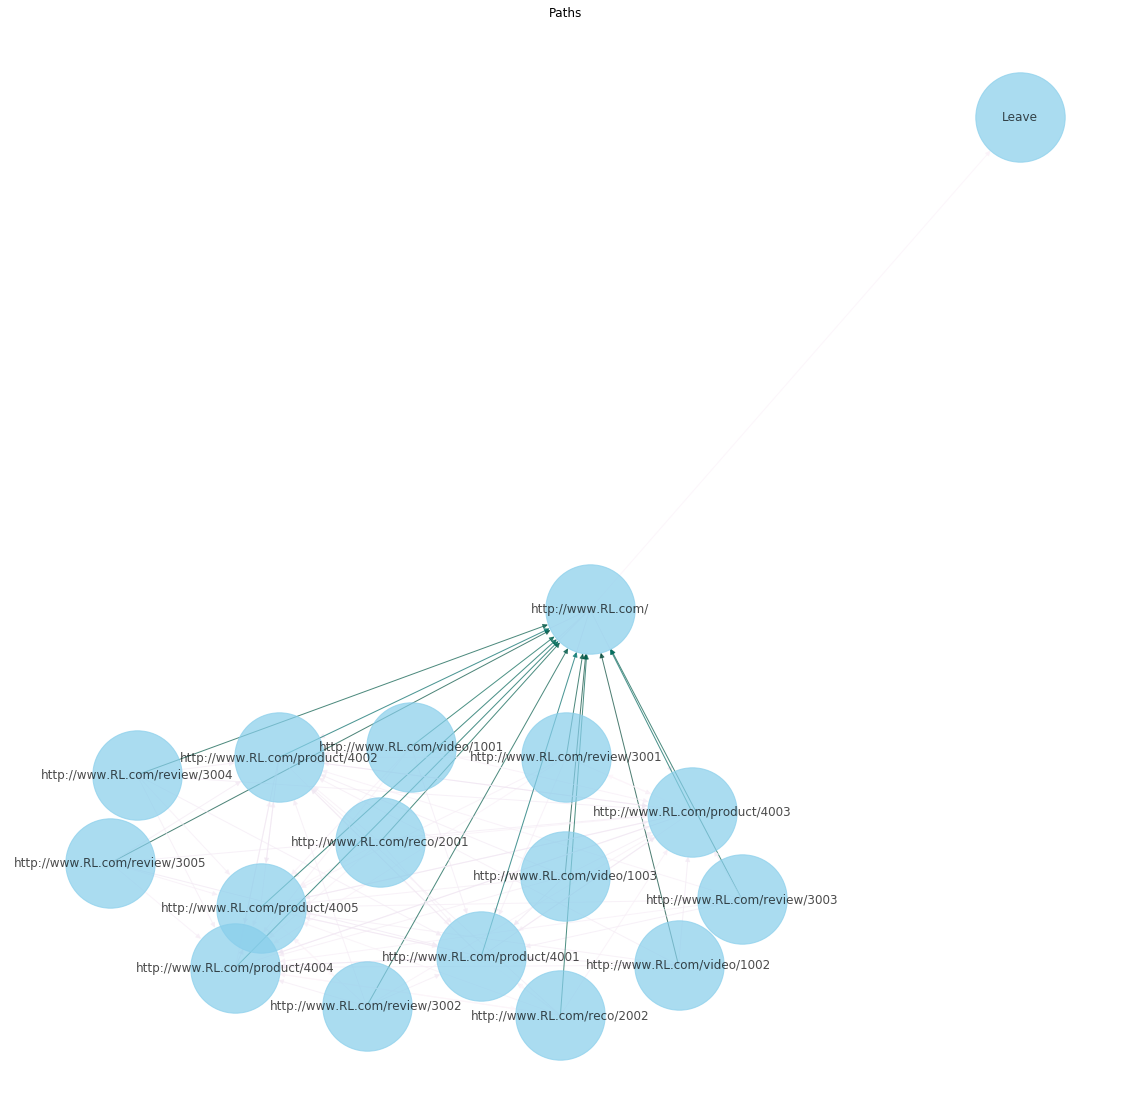

In [1395]:
# Graph
G = nx.from_pandas_edgelist(paths_subset, 'url', 'next_url', ['probability'], create_using=nx.DiGraph())

edges,weights = zip(*nx.get_edge_attributes(G,'probability').items())

plt.subplots(figsize = (20, 20))

edge_clr = plt.cm.PuBuGn

plt.title('Paths')
nx.draw_spring(G, node_color = 'skyblue', node_size = 8000, edge_color = weights, with_labels= True, alpha=0.7,
              edge_cmap = edge_clr, edge_vmin = min(weights), edge_vmax=max(weights))

## Path Buyers<a class="anchor" id="buyers"></a>

We see no different path for buyers, with the most common next click being the homepage at about 35% probability, all other links having probability of 6-7%.

In [1396]:
# Identify all IDs for purchases of products 1-5
purchasers = clickstream_data[(clickstream_data['is_purchased'] == 1)]['IP_address'].unique()

# Create copy of dataset to work with
path_buyers = clickstream_data[['timestamp', 'IP_address','url', 'IP_click_count']].copy()
path_buyers = path_buyers[path_buyers['IP_address'].isin(purchasers)]
path_buyers['next_url'] = path_buyers['url'].shift(-1)

# Correct final click for the IP by setting it to "Leave"
path_buyers['next_url'] = np.where(path_buyers['IP_click_count'] >= path_buyers['IP_click_count'].shift(-1), 'Leave', path_buyers['next_url'] )

path_buyers = path_buyers.groupby(['url', 'next_url'])['IP_click_count'].agg([('click_count', 'count')])
path_buyers['probability'] = path_buyers / path_buyers.groupby(level=0).sum()
path_buyers.reset_index(inplace=True)

path_buyers_subset = path_buyers.sort_values('probability', ascending = False).groupby('url').head(7)

In [1398]:
path_buyers_subset[path_buyers_subset['url'].str.contains('review') ].sort_values(['url','probability'], ascending = False).head(20)

url                        next_url  \
205  http://www.RL.com/review/3005              http://www.RL.com/   
206  http://www.RL.com/review/3005  http://www.RL.com/product/4001   
207  http://www.RL.com/review/3005  http://www.RL.com/product/4002   
208  http://www.RL.com/review/3005  http://www.RL.com/product/4003   
209  http://www.RL.com/review/3005  http://www.RL.com/product/4004   
217  http://www.RL.com/review/3005   http://www.RL.com/review/3005   
210  http://www.RL.com/review/3005  http://www.RL.com/product/4005   
188  http://www.RL.com/review/3004              http://www.RL.com/   
191  http://www.RL.com/review/3004  http://www.RL.com/product/4003   
190  http://www.RL.com/review/3004  http://www.RL.com/product/4002   
189  http://www.RL.com/review/3004  http://www.RL.com/product/4001   
192  http://www.RL.com/review/3004  http://www.RL.com/product/4004   
193  http://www.RL.com/review/3004  http://www.RL.com/product/4005   
199  http://www.RL.com/review/3004   http://www.RL.com/review/3004   
171  http://www.RL.com/review/3003              http://www.RL.com/   
172  http://www.RL.com/review/3003  http://www.RL.com/product/4001   
174  http://www.RL.com/review/3003  http://www.RL.com/product/4003   
176  http://www.RL.com/review/3003  http://www.RL.com/product/4005   
175  http://www.RL.com/review/3003  http://www.RL.com/product/4004   
173  http://www.RL.com/review/3003  http://www.RL.com/product/4002   

     click_count  probability  
205         3610     0.359454  
206          703     0.069999  
207          619     0.061635  
208          617     0.061436  
209          563     0.056059  
217          547     0.054466  
210          542     0.053968  
188         3486     0.352656  
191          612     0.061912  
190          602     0.060900  
189          596     0.060293  
192          578     0.058472  
193          567     0.057360  
199          493     0.049874  
171         3460     0.352378  
172          600     0.061106  
174          568     0.057847  
176          560     0.057032  
175          534     0.054384  
173          532     0.054181

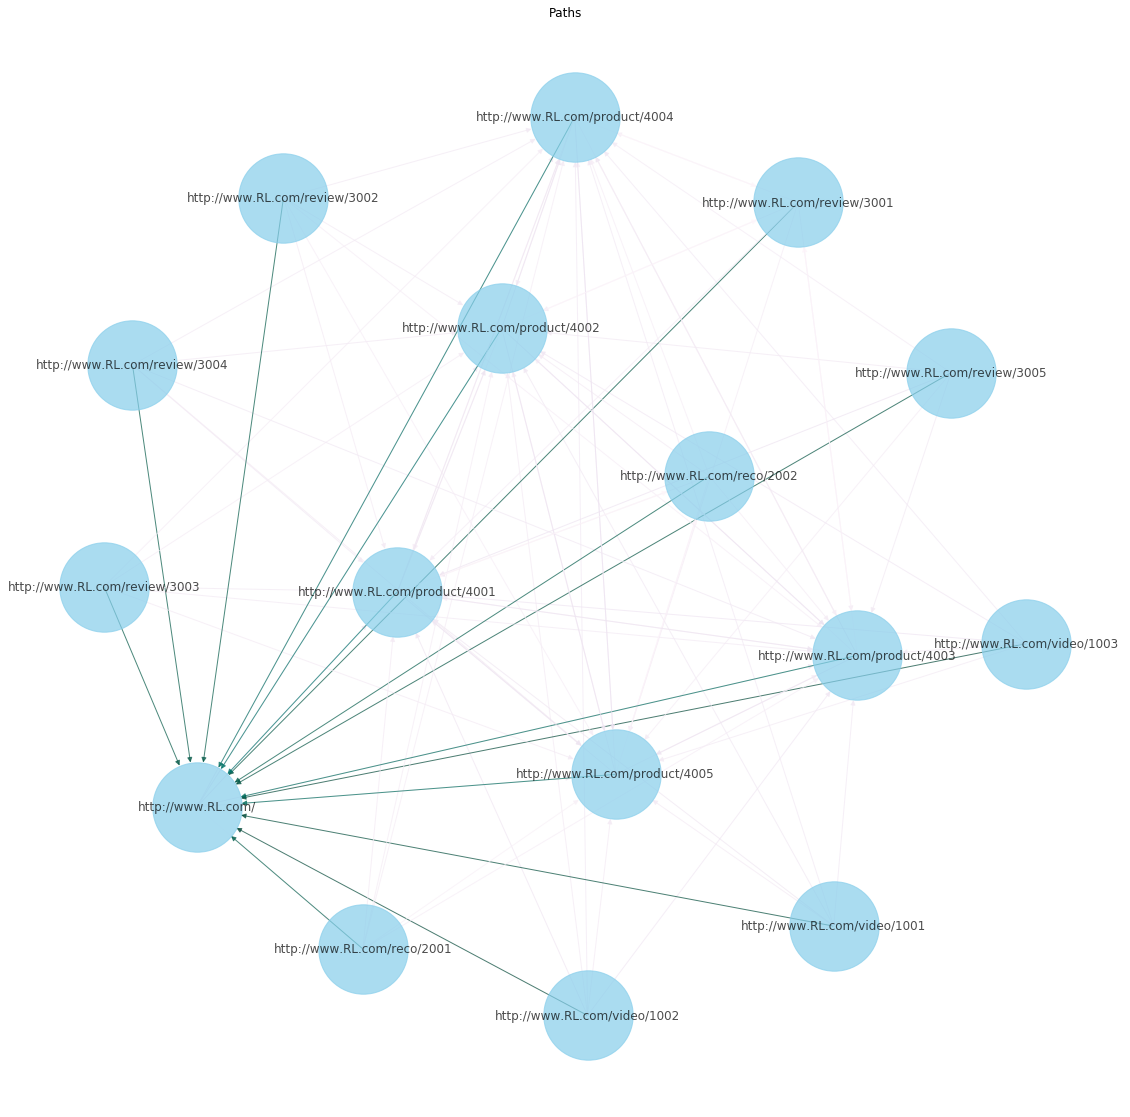

In [1399]:
# Graph
G = nx.from_pandas_edgelist(path_buyers_subset, 'url', 'next_url', ['probability'], create_using=nx.DiGraph())

edges,weights = zip(*nx.get_edge_attributes(G,'probability').items())

plt.subplots(figsize = (20, 20))

edge_clr = plt.cm.PuBuGn

plt.title('Paths')
nx.draw_spring(G, node_color = 'skyblue', node_size = 8000, edge_color = weights, with_labels= True, alpha=0.7,
              edge_cmap = edge_clr, edge_vmin = min(weights), edge_vmax=max(weights))

## Path Non-Buyers<a class="anchor" id="nonbuyers"></a>

Similarly, for non-buyers, we see the same pattern, with the most likely next click being the homepage. What is different here is that the 2nd most probable click is to leave with about 2% margin from the 3rd most popular click.

In [1400]:
# Create copy of dataset to work with
path_non_buyers = clickstream_data[['timestamp', 'IP_address','url', 'IP_click_count']].copy()
path_non_buyers = path_non_buyers[~path_non_buyers['IP_address'].isin(purchasers)]
path_non_buyers['next_url'] = path_non_buyers['url'].shift(-1)

# Correct final click for the IP by setting it to "Leave"
path_non_buyers['next_url'] = np.where(path_non_buyers['IP_click_count'] >= path_non_buyers['IP_click_count'].shift(-1), 'Leave', path_non_buyers['next_url'] )

path_non_buyers = path_non_buyers.groupby(['url', 'next_url'])['IP_click_count'].agg([('click_count', 'count')])
path_non_buyers['probability'] = path_non_buyers / path_non_buyers.groupby(level=0).sum()
path_non_buyers.reset_index(inplace=True)

path_non_buyers_subset = path_non_buyers.sort_values('probability', ascending = False).groupby('url').head(7)

In [1401]:
path_non_buyers_subset[path_non_buyers_subset['url'].str.contains('review') ].sort_values(['url','probability'], ascending = False).head(20)

url                        next_url  \
205  http://www.RL.com/review/3005              http://www.RL.com/   
204  http://www.RL.com/review/3005                           Leave   
206  http://www.RL.com/review/3005  http://www.RL.com/product/4001   
217  http://www.RL.com/review/3005   http://www.RL.com/review/3005   
207  http://www.RL.com/review/3005  http://www.RL.com/product/4002   
208  http://www.RL.com/review/3005  http://www.RL.com/product/4003   
210  http://www.RL.com/review/3005  http://www.RL.com/product/4005   
188  http://www.RL.com/review/3004              http://www.RL.com/   
187  http://www.RL.com/review/3004                           Leave   
199  http://www.RL.com/review/3004   http://www.RL.com/review/3004   
189  http://www.RL.com/review/3004  http://www.RL.com/product/4001   
190  http://www.RL.com/review/3004  http://www.RL.com/product/4002   
191  http://www.RL.com/review/3004  http://www.RL.com/product/4003   
192  http://www.RL.com/review/3004  http://www.RL.com/product/4004   
171  http://www.RL.com/review/3003              http://www.RL.com/   
170  http://www.RL.com/review/3003                           Leave   
181  http://www.RL.com/review/3003   http://www.RL.com/review/3003   
172  http://www.RL.com/review/3003  http://www.RL.com/product/4001   
176  http://www.RL.com/review/3003  http://www.RL.com/product/4005   
174  http://www.RL.com/review/3003  http://www.RL.com/product/4003   

     click_count  probability  
205         1300     0.361211  
204          296     0.082245  
206          198     0.055015  
217          195     0.054182  
207          189     0.052515  
208          172     0.047791  
210          153     0.042512  
188         1243     0.346626  
187          237     0.066090  
199          199     0.055494  
189          185     0.051590  
190          181     0.050474  
191          173     0.048243  
192          166     0.046291  
171         1193     0.331481  
170          279     0.077522  
181          205     0.056960  
172          181     0.050292  
176          180     0.050014  
174          175     0.048625

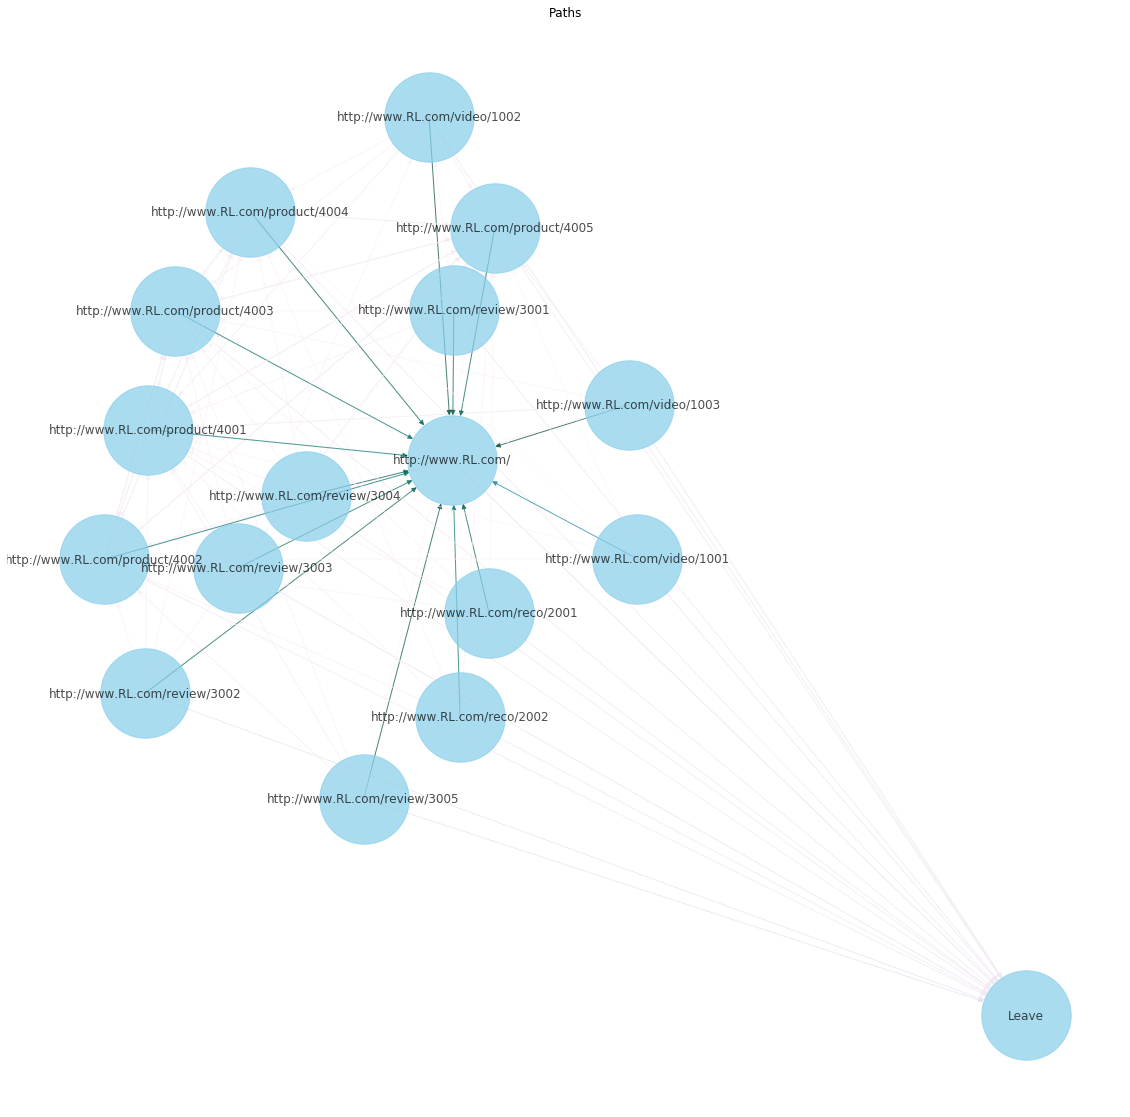

In [1402]:
# Graph
G = nx.from_pandas_edgelist(path_non_buyers_subset, 'url', 'next_url', ['probability'], create_using=nx.DiGraph())

edges,weights = zip(*nx.get_edge_attributes(G,'probability').items())

plt.subplots(figsize = (20, 20))

edge_clr = plt.cm.PuBuGn

plt.title('Paths')
nx.draw_spring(G, node_color = 'skyblue', node_size = 8000, edge_color = weights, with_labels= True, alpha=0.7,
              edge_cmap = edge_clr, edge_vmin = min(weights), edge_vmax=max(weights))

## Path Males<a class="anchor" id="males"></a>

In [1407]:
# Identify all IDs for purchases of products 1-5
males = clickstream_data[clickstream_data['GENDER_CD'] == 'M']['IP_address'].unique()

# Create copy of dataset to work with
path_male = clickstream_data[['timestamp', 'IP_address','url', 'IP_click_count']].copy()
path_male = path_male[path_male['IP_address'].isin(males)]
path_male['next_url'] = path_male['url'].shift(-1)

# Correct final click for the IP by setting it to "Leave"
path_male['next_url'] = np.where(path_male['IP_click_count'] >= path_male['IP_click_count'].shift(-1),
                                 'Leave', 
                                 path_male['next_url'] )

path_male = path_male.groupby(['url', 'next_url'])['IP_click_count'].agg([('click_count', 'count')])
path_male['probability'] = path_male / path_male.groupby(level=0).sum()
path_male.reset_index(inplace=True)

path_male_subset = path_male.sort_values('probability', ascending = False).groupby('url').head(7)

In [1409]:
path_male_subset[path_male_subset['url'].str.contains('review') ].sort_values(['url','probability'], ascending = False).head(20)

url                        next_url  \
205  http://www.RL.com/review/3005              http://www.RL.com/   
206  http://www.RL.com/review/3005  http://www.RL.com/product/4001   
207  http://www.RL.com/review/3005  http://www.RL.com/product/4002   
208  http://www.RL.com/review/3005  http://www.RL.com/product/4003   
217  http://www.RL.com/review/3005   http://www.RL.com/review/3005   
210  http://www.RL.com/review/3005  http://www.RL.com/product/4005   
209  http://www.RL.com/review/3005  http://www.RL.com/product/4004   
188  http://www.RL.com/review/3004              http://www.RL.com/   
190  http://www.RL.com/review/3004  http://www.RL.com/product/4002   
191  http://www.RL.com/review/3004  http://www.RL.com/product/4003   
193  http://www.RL.com/review/3004  http://www.RL.com/product/4005   
192  http://www.RL.com/review/3004  http://www.RL.com/product/4004   
189  http://www.RL.com/review/3004  http://www.RL.com/product/4001   
199  http://www.RL.com/review/3004   http://www.RL.com/review/3004   
171  http://www.RL.com/review/3003              http://www.RL.com/   
174  http://www.RL.com/review/3003  http://www.RL.com/product/4003   
172  http://www.RL.com/review/3003  http://www.RL.com/product/4001   
176  http://www.RL.com/review/3003  http://www.RL.com/product/4005   
181  http://www.RL.com/review/3003   http://www.RL.com/review/3003   
175  http://www.RL.com/review/3003  http://www.RL.com/product/4004   

     click_count  probability  
205         1602     0.364422  
206          286     0.065059  
207          265     0.060282  
208          263     0.059827  
217          251     0.057097  
210          216     0.049136  
209          216     0.049136  
188         1560     0.355515  
190          263     0.059936  
191          263     0.059936  
193          257     0.058569  
192          254     0.057885  
189          250     0.056974  
199          220     0.050137  
171         1514     0.348607  
174          263     0.060557  
172          261     0.060097  
176          243     0.055952  
181          224     0.051577  
175          215     0.049505

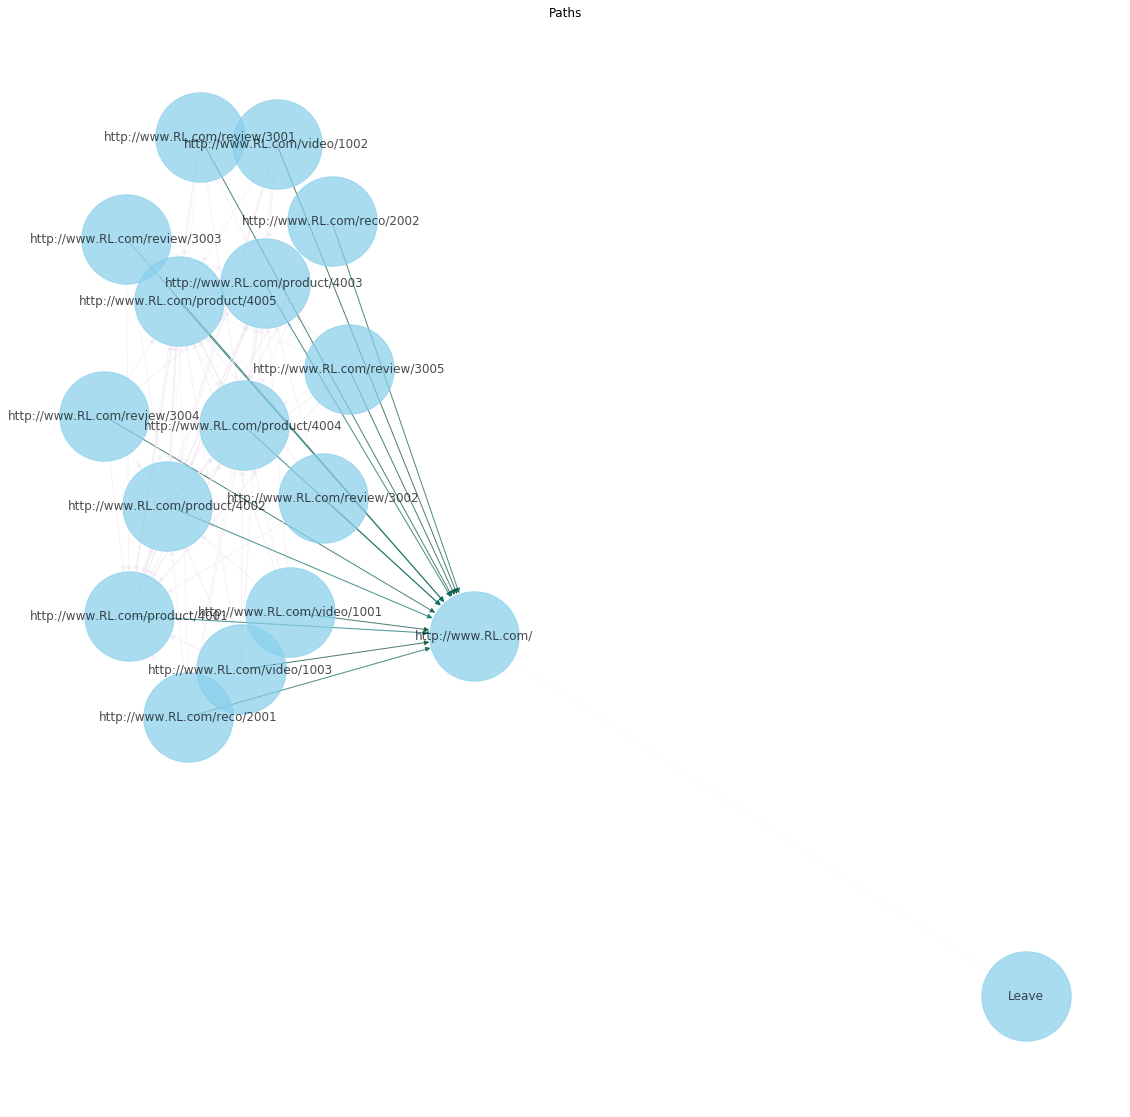

In [1410]:
# Graph
G = nx.from_pandas_edgelist(path_male_subset, 'url', 'next_url', ['probability'], create_using=nx.DiGraph())

edges,weights = zip(*nx.get_edge_attributes(G,'probability').items())

plt.subplots(figsize = (20, 20))

edge_clr = plt.cm.PuBuGn

plt.title('Paths')
nx.draw_spring(G, node_color = 'skyblue', node_size = 8000, edge_color = weights, with_labels= True, alpha=0.7,
              edge_cmap = edge_clr, edge_vmin = min(weights), edge_vmax=max(weights))

## Path Females<a class="anchor" id="females"></a>

In [1411]:
# Create copy of dataset to work with
path_female = clickstream_data[['timestamp', 'IP_address','url', 'IP_click_count']].copy()
path_female = path_female[ ~ path_female['IP_address'].isin(males)]
path_female['next_url'] = path_female['url'].shift(-1)

# Correct final click for the IP by setting it to "Leave"
path_female['next_url'] = np.where(path_female['IP_click_count'] >= path_female['IP_click_count'].shift(-1),
                                 'Leave', 
                                 path_female['next_url'] )

path_female = path_female.groupby(['url', 'next_url'])['IP_click_count'].agg([('click_count', 'count')])
path_female['probability'] = path_female / path_female.groupby(level=0).sum()
path_female.reset_index(inplace=True)

path_female_subset = path_female.sort_values('probability', ascending = False).groupby('url').head(7)

In [1412]:
path_female_subset[path_female_subset['url'].str.contains('review') ].sort_values(['url','probability'], ascending = False).head(20)

url                        next_url  \
205  http://www.RL.com/review/3005              http://www.RL.com/   
206  http://www.RL.com/review/3005  http://www.RL.com/product/4001   
207  http://www.RL.com/review/3005  http://www.RL.com/product/4002   
208  http://www.RL.com/review/3005  http://www.RL.com/product/4003   
217  http://www.RL.com/review/3005   http://www.RL.com/review/3005   
209  http://www.RL.com/review/3005  http://www.RL.com/product/4004   
210  http://www.RL.com/review/3005  http://www.RL.com/product/4005   
188  http://www.RL.com/review/3004              http://www.RL.com/   
189  http://www.RL.com/review/3004  http://www.RL.com/product/4001   
191  http://www.RL.com/review/3004  http://www.RL.com/product/4003   
190  http://www.RL.com/review/3004  http://www.RL.com/product/4002   
192  http://www.RL.com/review/3004  http://www.RL.com/product/4004   
193  http://www.RL.com/review/3004  http://www.RL.com/product/4005   
199  http://www.RL.com/review/3004   http://www.RL.com/review/3004   
171  http://www.RL.com/review/3003              http://www.RL.com/   
172  http://www.RL.com/review/3003  http://www.RL.com/product/4001   
176  http://www.RL.com/review/3003  http://www.RL.com/product/4005   
181  http://www.RL.com/review/3003   http://www.RL.com/review/3003   
174  http://www.RL.com/review/3003  http://www.RL.com/product/4003   
175  http://www.RL.com/review/3003  http://www.RL.com/product/4004   

     click_count  probability  
205         3308     0.357776  
206          615     0.066515  
207          543     0.058728  
208          526     0.056889  
217          491     0.053104  
209          489     0.052888  
210          479     0.051806  
188         3169     0.348894  
189          531     0.058461  
191          522     0.057470  
190          520     0.057250  
192          490     0.053947  
193          473     0.052075  
199          472     0.051965  
171         3139     0.345895  
172          520     0.057300  
176          497     0.054766  
181          491     0.054105  
174          480     0.052893  
175          479     0.052782

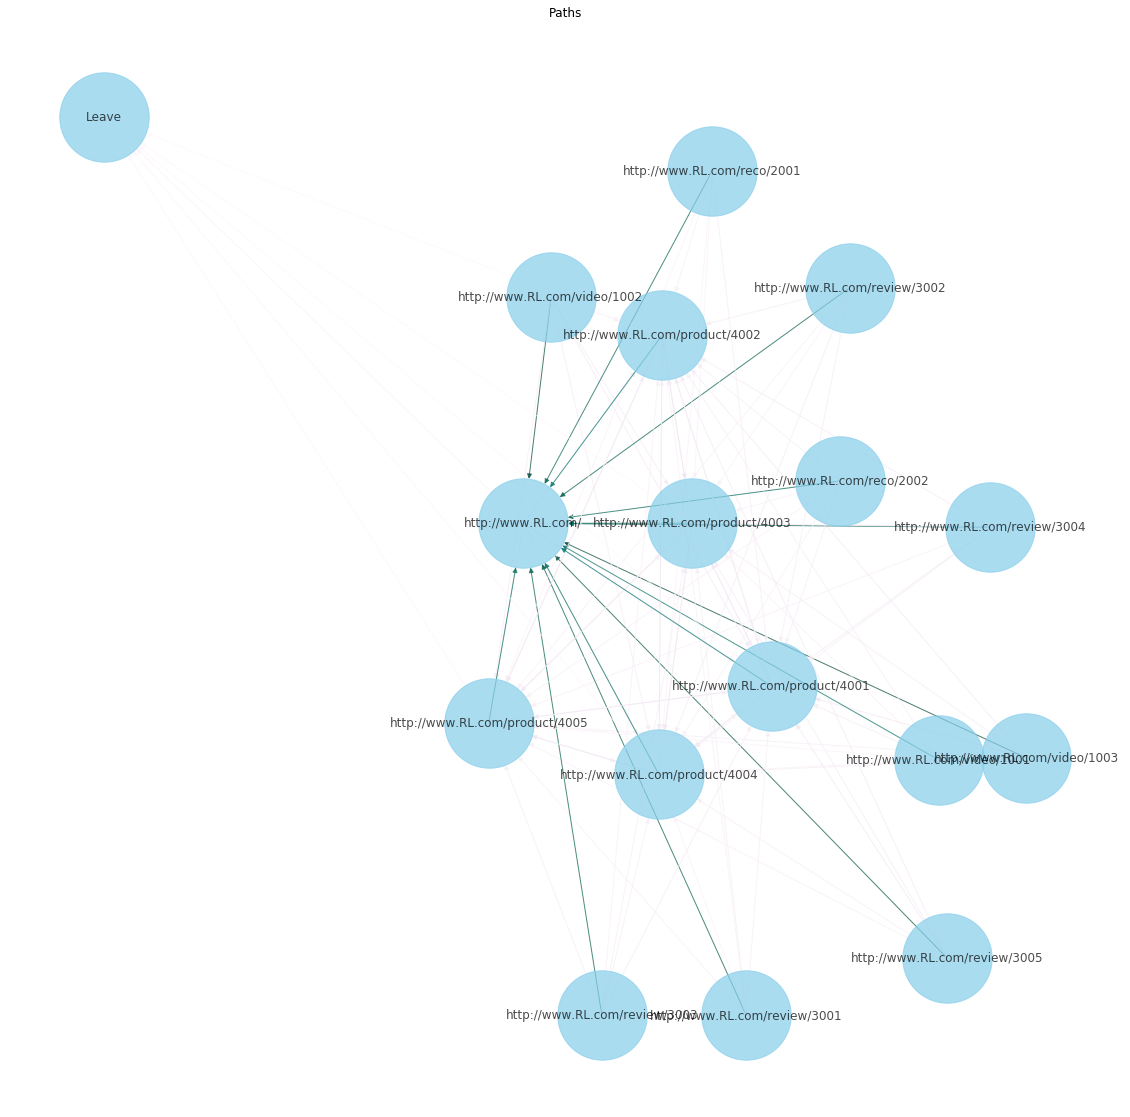

In [1413]:
# Graph
G = nx.from_pandas_edgelist(path_female_subset, 'url', 'next_url', ['probability'], create_using=nx.DiGraph())

edges,weights = zip(*nx.get_edge_attributes(G,'probability').items())

plt.subplots(figsize = (20, 20))

edge_clr = plt.cm.PuBuGn

plt.title('Paths')
nx.draw_spring(G, node_color = 'skyblue', node_size = 8000, edge_color = weights, with_labels= True, alpha=0.7,
              edge_cmap = edge_clr, edge_vmin = min(weights), edge_vmax=max(weights))